In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from dataset.traffic_dataset import TrafficDataset
from utils.Trainer import Trainer
import numpy as np
from models.baselines import GCNMLP, DCRNN, STGCN, MLPBASED, STGAT
import os
import matplotlib.pyplot as plt
from collections import defaultdict
from dataset.dataset_config import edge_index, edge_attr, week_steps

In [2]:
# MAPE
class MAPELoss(nn.Module):
    """
    안정화를 위해 true 값이 작은 경우 eps로 클램프한 후 계산합니다.
    """
    def __init__(self, eps: float = 1e-3):
        super().__init__()
        self.eps = eps

    def forward(self, pred: torch.Tensor, true: torch.Tensor) -> torch.Tensor:
        # 분모가 너무 작아지는 것을 방지
        denom = torch.clamp(true.abs(), min=self.eps)
        loss = torch.abs((pred - true) / denom)
        return loss.mean()


In [3]:
# 하이퍼파라미터 & 데이터셋 준비
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-3
WINDOW = 12                   # 입력 시퀀스 길이
N_PRED = 3                    # 예측 시퀀스 길이
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

data = np.load('dataset/traffic_dataset_13_smoothen.npy')  # (T_total, E, C_all)
# train/valid split (예: 시계열 뒤쪽 20%를 검증으로)


split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [4]:
# 공통 파라미터 및 모델 목록 정의

DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'
WINDOW       = 12
PRED_OFFSETS = np.array([3, 6, 12])
EDGE_IDS     = [2]                  # 시각화할 edge index 리스트
T_TOTAL      = data.shape[0]        # 전체 타임스텝 수
SAVE_DIR     = "./checkpoints"      
os.makedirs(SAVE_DIR, exist_ok=True)

models = {
#    "GCNMLP":    GCNMLP,
#    "DCRNN":     DCRNN,
    "STGCN":     STGCN,
#    "MLPBASED":  MLPBASED,
#    "STGAT": STGAT,
}

In [ ]:
# Training

for name, ModelClass in models.items():
    print(f"\n=== Training {name} ===")
    # (1) 배치 데이터에서 차원 정보 추출
    x_sample, y_sample = next(iter(train_loader))
    _, T, E, D_in = x_sample.shape
    _, _, _, D_out = y_sample.shape
    n_pred = y_sample.size(1)

    # (2) 모델 인스턴스화
    if name == "MLPBASED":
        model = ModelClass(T=T, E=E, D_in=D_in, n_pred=n_pred, D_out=D_out,
                           hidden_dim=256, dropout=0.1)
    else:
        # GCNMLP, DCRNN, STGCN 공통 생성자 인자
        kwargs = dict(
            num_nodes=E, node_feature_dim=D_in,
            pred_node_dim=D_out, n_pred=n_pred,
            encoder_embed_dim=256, encoder_depth=3,
            dropout=0.1
        )
        if name == "DCRNN":
            kwargs.update(K=2)
        elif name == "STGCN":
            kwargs.update(kernel_size=3, K=2)
        elif name == "GCNMLP":
            kwargs.update(mlp_hidden_dim=16, mlp_pred_dropout=0.0)
        elif name == "STGAT":
            kwargs.update(encoder_depth=2, kernel_size=3, heads=4)

        model = ModelClass(**kwargs)

    model = model.to(DEVICE)

    # (3) 옵티마이저·손실함수 설정
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    criterion = torch.nn.L1Loss()

    # (4) Trainer 초기화·학습
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=1,
        device=DEVICE
    )
    trainer.fit()

    # (5) 가중치 저장
    # save_path = os.path.join(SAVE_DIR, f"{name}.pth")
    # torch.save(model.state_dict(), save_path)
    # print(f"Saved checkpoint: {save_path}")



--- Visualizing STGCN ---


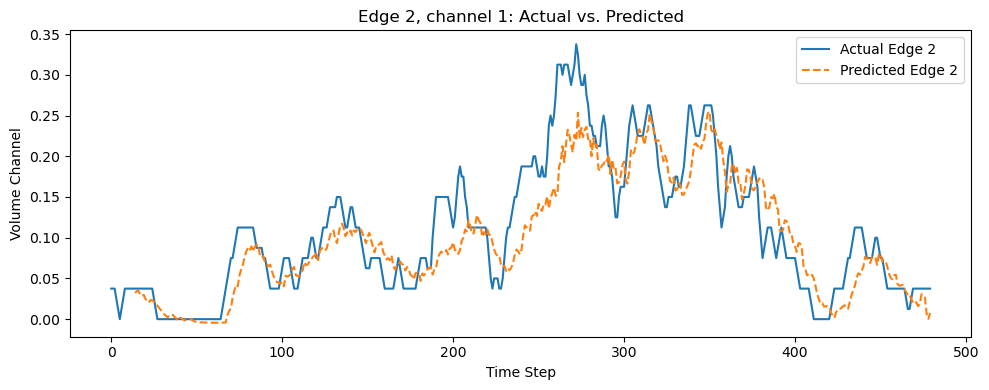

In [ ]:
from dataset.traffic_dataset import EDGE_INDEX, EDGE_ATTR
from dataset.dataset_config import week_steps, C_origin
from utils.edge_prediction_visualization import visualize_predictions, add_tod_dow
EDGE_INDEX = EDGE_INDEX.to(DEVICE)
EDGE_ATTR = EDGE_ATTR.to(DEVICE)

# ─────────────────────────────────────────────────────────
# 4) 저장된 체크포인트 로드 후 일괄 시각화
# ─────────────────────────────────────────────────────────


for name, ModelClass in models.items():
    # (1) 모델 재생성 (학습 시와 동일한 인자 사용)
    #    -- 이하 2)~3)은 학습 루프와 동일하게 구성합니다.
    x_sample, y_sample = next(iter(train_loader))
    _, T, E, D_in = x_sample.shape
    _, _, _, D_out = y_sample.shape
    n_pred = y_sample.size(1)

    if name == "MLPBASED":
        model = ModelClass(T=T, E=E, D_in=D_in, n_pred=n_pred, D_out=D_out,
                           hidden_dim=256, dropout=0.1)
    else:
        kwargs = dict(
            num_nodes=E, node_feature_dim=D_in,
            pred_node_dim=D_out, n_pred=n_pred,
            encoder_embed_dim=32, encoder_depth=1,
            dropout=0.0
        )
        if name == "DCRNN":
            kwargs.update(K=2)
        elif name == "STGCN":
            kwargs.update(kernel_size=3, K=2)
        elif name == "GCNMLP":
            kwargs.update(mlp_hidden_dim=16, mlp_pred_dropout=0.0)
        elif name == "STGAT":
            kwargs.update(encoder_depth=2, kernel_size=3, heads=4)

        model = ModelClass(**kwargs)

    # (2) 가중치 로드 (임시. 나중에 수정해야 함.)
    if name == "STGCN":
        ckpt_path = os.path.join(SAVE_DIR, f"{name}_h32_el1.pth")
    else:
        ckpt_path = os.path.join(SAVE_DIR, f"{name}.pth")
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE, weights_only=True))
    model = model.to(DEVICE)

    print(f"\n--- Visualizing {name} ---")
    EDGE_IDS = [2]
    expanded_data = add_tod_dow(data, week_steps=week_steps, C_origin=C_origin)
    visualize_predictions(model, expanded_data, EDGE_IDS, DEVICE, EDGE_INDEX, EDGE_ATTR, interval=(480*5,480*6), channel=1)
